# #5. Black-Litterman model

#### #5.9 블랙-리터만 모델 최적화 (p 199)

Optimization condition for BL model:

\begin{align*}
    \max \Sigma_{i=1}^n \mu BL_i &- \frac{\lambda}{2} \Sigma_{i=1}^n \Sigma_{j=1}^n \sigma_{ij} w_i w_j \\
    \text{Subject to} \quad \Sigma_{i=1}^n w_i &=
    
     1, w_i \geq 0. i=1, 2, 3, \ldots, n
\end{align*}

; this enables us to compute the weights $w_i$ for asset allocation.

아래는 Sharpe 비율을 최대로하는 tangency portfolio 최적화를 수행하는 코드다:

In [1]:
import matplotlib.pylab as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd
# from pandas_datareader import data as web
from scipy.optimize import minimize

In [2]:
# 샤프비율을 maximize하는 tangency 포트폴리오 비중을 계산하는 함수
def solveWeights(R, C, rf):
    # 최적의 비중 계산을 위한 목적함수, obj. funciton for optimizing weights
    def obj(W, R, C, rf):
        mean = sum (R * W)
        var = np.dot(np.dot(W, C), W)
        
        # Sharpe's ratio as utility function: want to maximize
        util = (mean -rf) / np.sqrt(var)
        return 1 / util
    
    # number of assets
    n = len(R)
    
    # initial weights
    W = np.ones([n]) / n
    
    # doesn't allow short-selling nor borrowing
    # 비중 범위는 0-100% 사이: 공매도나 차입조건이 없음
    bnds = [(0., 1.) for i in range(n)]
    
    # constraints: sum of weights = 1
    cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})

    # W는 초기값, (R, C, rf)는 추가 인수
    res = minimize(obj, W, (R, C, rf), method='SLSQP', constraints=cons, bounds=bnds)

    # res.success: 최적화(minimize())가 성공적으로 수행되었는지를 나타내는 Boolean 값
    # False이면 res.message로 그 원인을 알 수 있다
    if not res.success:
        raise BaseException(res.message)
    
    return res.x

In [3]:
# example 1
R = np.array([0.05, 0.08])  # 자산 기대수익률
C = np.array([[0.01, 0.02],
              [0.02, 0.04]])  # 자산 공분산
rf = 0.02  # 무위험 이자율
weights = solveWeights(R, C, rf)  # 최적 비중 계산

print("Optimal Weights:", weights)

Optimal Weights: [0.5 0.5]


In [4]:
# example 2
R = [0.05, 0.08, 0.12]  # 자산의 기대수익률
C = [[0.04, 0.02, 0.01],
     [0.02, 0.09, 0.03],
     [0.01, 0.03, 0.06]]  # 자산들 간의 공분산 행렬
rf = 0.03  # 무위험 이자율

weights = solveWeights(R, C, rf)
print(weights)

[0.07040263 0.02735284 0.90224453]


In [5]:
# 무위험 수익률, 수익률, Cov로 효율적 투자선 계산
# calculating Efficient Frontier via risk-less rate, return rate and the Covariance
def solveFrontier(R, C, rf):

    # 최적 비중 계산을 위한 목적함수
    def obj(W, R, C, r):

        # 주어진 수익률에서 분산을 최소화하는 비중 계산
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)

        # 최적화 제약조건 페널티
        penalty = 100 * abs(mean - r)
        return var + penalty
    
    # eff. frontier의 평균과 분산이 될 list
    frontier_mean, frontier_var = [ ], [ ]
    n = len(R)
    
    # 수익률 최저에서 최대 사이에서 목표 수익률(r)을 다양하게 설정하여 포트폴리오 최적화를 반복
    for r in np.linspace(min(R), max(R), num=20):
        W = np.ones([n]) / n
        bnds = [(0, 1) for i in range(n)]
        cons = [{'type': 'eq', 'fun': lambda W: sum(W) - 1.}]

        res = minimize(obj, W, (R, C, r), method='SLSQP', constraints=cons, bounds=bnds)

        if not res.success:
            raise BaseException(res.message)
        
        frontier_mean.append(r)
        frontier_var.append(np.dot(np.dot(res.x, C), res.x))

    return np.array(frontier_mean), np.array(frontier_var)

위 코드에서 obj. f'tn의 penalty 항(이를 minimize하길 원한다)을 주목해보자:

이러한 패널티는 효율적인 포트폴리오 최적화를 위해 사용된다. 목표 수익률과 실제 포트폴리오의 수익률이 일치하는 경우에는 패널티가 없다. 그러나 목표 수익률과 포트폴리오 수익률 간에 차이가 클수록 패널티가 증가한다.

이를 통해, 목표 수익률과 가능한 작은 분산을 동시에 달성하는 포트폴리오를 찾기 위해 최적화 과정에서 목표 수익률에 가까운 포트폴리오를 선호하도록 유도한다. 따라서 목적함수에 패널티 항을 추가하여 수익률과 분산의 트레이드오프를 조정하고 최적의 포트폴리오를 찾을 수 있게 된다.

In [6]:
# example
R = np.array([0.08, 0.12, 0.15])  # 수익률
C = np.array([[0.02, 0.005, 0.01], 
              [0.005, 0.03, 0.02], 
              [0.01, 0.02, 0.04]])  # 공분산
rf = 0.05  # 무위험 이자율

# Efficient Frontier 계산
frontier_mean, frontier_var = solveFrontier(R, C, rf)

# 결과 출력
for mean, var in zip(frontier_mean, frontier_var):
    print(f"Mean Return: {mean:.4f}, Variance: {var:.4f}")

Mean Return: 0.0800, Variance: 0.0200
Mean Return: 0.0837, Variance: 0.0176
Mean Return: 0.0874, Variance: 0.0158
Mean Return: 0.0911, Variance: 0.0148
Mean Return: 0.0947, Variance: 0.0144
Mean Return: 0.0984, Variance: 0.0152
Mean Return: 0.1021, Variance: 0.0146
Mean Return: 0.1058, Variance: 0.0151
Mean Return: 0.1095, Variance: 0.0158
Mean Return: 0.1132, Variance: 0.0167
Mean Return: 0.1168, Variance: 0.0178
Mean Return: 0.1205, Variance: 0.0192
Mean Return: 0.1242, Variance: 0.0208
Mean Return: 0.1279, Variance: 0.0225
Mean Return: 0.1316, Variance: 0.0246
Mean Return: 0.1353, Variance: 0.0268
Mean Return: 0.1389, Variance: 0.0292
Mean Return: 0.1426, Variance: 0.0320
Mean Return: 0.1463, Variance: 0.0355
Mean Return: 0.1500, Variance: 0.0400


In [7]:
# 효율적 포트폴리오 최적화
def optimize_frontier(R, C, rf):

    # tangency portfolio 계산
    W = solveWeights(R, C, rf)

    tan_mean = sum(R * W)
    tan_var = np.dot(np.dot(W, C), W)

    # 효율적 포트폴리오 계산
    eff_mean, eff_var = solveFrontier(R, C, rf)
    
    # dict 타입으로 리턴
    return {'weights':W, 'tan_mean':tan_mean, 'tan_var':tan_var, 'eff_mean':eff_mean, 'eff_var':eff_var}

In [8]:
# 자산에 대한 투자자의 전망 (행렬)과 전망의 기대수익률 행렬
# names은 tickers다
def CreateMatrixPQ(names, views):
    r, c = len(views), len(names)

    # Q: 기대 수익률 행렬
    # views[i][3] = exp. return(기대 수익률): 아래 예시들 참고
    Q = [views[i][3] for i in range(r)]
    
    # 전망 행렬 P을 만들기위한 구성 자산 dict.
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    
    # 투자자의 전망 행렬
    P = np.zeros([r, c])
    for i, v in enumerate(views):
        # 가령 전망이 ('MSFT', '>', 'GE', 0.02) 이라면
        # views[i][0] <-- 'MSFT' --> name1
        # views[i][1] <-- '>'
        # views[i][2] <-- 'GE'   --> name2
        # views[i][3] <-- '0.02'
        name1, name2 = views[i][0], views[i][2]
        P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    
    return np.array(Q), P

In [9]:
# example 1 (p 189)
tickers = ['XOM', 'JPM', 'NFLX', 'JNJ']
views1 = [('XOM', '>', 'JPM', 0.02), ('NFLX', '<', 'JNJ', 0.02)]
Q, P = CreateMatrixPQ(tickers, views1)

print(Q)
print(P)

[0.02 0.02]
[[ 1. -1.  0.  0.]
 [ 0.  0. -1.  1.]]


In [10]:
# example 2 (p 189-190)
tickers = ['MSFT', 'GE']
views2 = [('MSFT', '>', 'GE', 0.02)]
Q, P = CreateMatrixPQ(tickers, views2)

print(Q)
print(P)

[0.02]
[[ 1. -1.]]


In [11]:
# example 3
names = ['AAPL', 'GOOGL', 'AMZN', 'MSFT']
views = [['AAPL', '>', 'GOOGL', 0.03],
         ['AMZN', '<', 'MSFT', 0.02],
         ['GOOGL', '>', 'AAPL', 0.01]]

Q, P = CreateMatrixPQ(names, views)

print("기대 수익률 행렬 (Q):")
print(Q)
print("전망 행렬 (P):")
print(P)


기대 수익률 행렬 (Q):
[0.03 0.02 0.01]
전망 행렬 (P):
[[ 1. -1.  0.  0.]
 [ 0.  0. -1.  1.]
 [-1.  1.  0.  0.]]


In [12]:
# read the data
tickers = ['PFE','INTC','NFLX','JPM','XOM','GOOG','JNJ','AAPL','AMZN']
cap = {'PFE':201102000000,'INTC':257259000000,'NFLX':184922000000,
       'JPM':272178000000,'XOM':178228000000,'GOOG':866683000000,
       'JNJ':403335000000,'AAPL':1208000000000,'AMZN':1178000000000
      }

prices, caps = [ ], [ ]

import yfinance as yf

for s in tickers:
    # pxclose = web.DataReader(s, data_source='yahoo', start='01-01-2018', end='31-12-2019')['Adj Close']
    pxclose = yf.download(s, start='2018-01-01', end='2019-12-31')['Adj Close']
    prices.append(list(pxclose))
    caps.append(cap[s])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
pxclose.head()

Date
2018-01-02    59.450500
2018-01-03    60.209999
2018-01-04    60.479500
2018-01-05    61.457001
2018-01-08    62.343498
Name: Adj Close, dtype: float64

In [14]:
pxclose

Date
2018-01-02    59.450500
2018-01-03    60.209999
2018-01-04    60.479500
2018-01-05    61.457001
2018-01-08    62.343498
                ...    
2019-12-23    89.650002
2019-12-24    89.460503
2019-12-26    93.438499
2019-12-27    93.489998
2019-12-30    92.344498
Name: Adj Close, Length: 502, dtype: float64

In [15]:
prices

[[28.254047393798828,
  28.46339988708496,
  28.525423049926758,
  28.57969856262207,
  28.261798858642578,
  28.23078727722168,
  28.277301788330078,
  28.34708595275879,
  28.331588745117188,
  28.378110885620117,
  28.827816009521484,
  28.680496215820312,
  28.6417236328125,
  28.63397216796875,
  28.548683166503906,
  28.63397216796875,
  28.8665828704834,
  30.246723175048828,
  30.254472732543945,
  29.30853271484375,
  28.719261169433594,
  28.82099723815918,
  28.648832321166992,
  27.13070297241211,
  27.608055114746094,
  27.373292922973633,
  26.316862106323242,
  26.731609344482422,
  27.122880935668945,
  27.341989517211914,
  27.537628173828125,
  27.94455337524414,
  28.374942779541016,
  28.179311752319336,
  27.983673095703125,
  27.968021392822266,
  28.374942779541016,
  29.024459838867188,
  28.797515869140625,
  28.414072036743164,
  27.881938934326172,
  28.132354736328125,
  28.265390396118164,
  28.07758331298828,
  28.1167049407959,
  28.562759399414062,
  28.

In [16]:
caps

[201102000000,
 257259000000,
 184922000000,
 272178000000,
 178228000000,
 866683000000,
 403335000000,
 1208000000000,
 1178000000000]

최적화에 쓰일 값을 미리 계산

In [17]:
n = len(tickers)
W = np.array(caps) / sum(caps)
prices = np.matrix(prices)

rows, cols = prices.shape
returns = np.empty([rows, cols - 1])
for r in range(rows):
    for c in range(cols - 1):
        p0, p1 = prices[r, c], prices[r, c + 1]
        returns[r, c] = (p1 / p0) - 1

# 수익률
expreturns = np.array([])
for r in range(rows):
    expreturns = np.append(expreturns, np.mean(returns[r]))

covars = np.cov(returns)
R = (1 + expreturns) ** 250 - 1  # 연율화 annualize
C = covars * 250

rf = .015

In [18]:
expreturns

array([ 0.00034886,  0.00076697,  0.00127909,  0.00068967, -0.00014778,
        0.00058903,  0.00026973,  0.00126127,  0.00106064])

In [19]:
display(pd.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=tickers).T)

,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Return,0.091115,0.211269,0.376532,0.188103,-0.036272,0.158603,0.069750,0.370421,0.303458
Weight (based on market cap),0.042340,0.054163,0.038933,0.057304,0.037524,0.182471,0.084918,0.254331,0.248015


In [20]:
display(pd.DataFrame(C, columns=tickers, index=tickers))

,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
PFE,0.037416,0.021683,0.026074,0.015826,0.015789,0.018568,0.018293,0.019736,0.021604
INTC,0.021683,0.093592,0.054494,0.029861,0.027049,0.039894,0.017541,0.045417,0.042485
NFLX,0.026074,0.054494,0.165585,0.031793,0.027628,0.060322,0.020999,0.053177,0.081516
JPM,0.015826,0.029861,0.031793,0.041864,0.022214,0.028071,0.014437,0.027651,0.029185
XOM,0.015789,0.027049,0.027628,0.022214,0.040405,0.024244,0.014398,0.023460,0.022576
GOOG,0.018568,0.039894,0.060322,0.028071,0.024244,0.068207,0.016347,0.044919,0.054470
JNJ,0.018293,0.017541,0.020999,0.014437,0.014398,0.016347,0.037293,0.015893,0.016443
AAPL,0.019736,0.045417,0.053177,0.027651,0.023460,0.044919,0.015893,0.075312,0.051415
AMZN,0.021604,0.042485,0.081516,0.029185,0.022576,0.054470,0.016443,0.051415,0.090683


In [21]:
"""과거 데이터를 이용한 최적화"""
# mean-var optimization
opt1 = optimize_frontier(R, C, rf)

In [22]:
opt1

{'weights': array([3.97540797e-18, 0.00000000e+00, 1.35820588e-01, 1.86697013e-01,
        1.09934754e-16, 0.00000000e+00, 0.00000000e+00, 6.76108028e-01,
        1.37437035e-03]),
 'tan_mean': 0.3371204143547632,
 'tan_var': 0.057441265052547576,
 'eff_mean': array([-0.03627248, -0.01454595,  0.00718059,  0.02890712,  0.05063365,
         0.07236018,  0.09408671,  0.11581324,  0.13753978,  0.15926631,
         0.18099284,  0.20271937,  0.2244459 ,  0.24617244,  0.26789897,
         0.2896255 ,  0.31135203,  0.33307856,  0.3548051 ,  0.37653163]),
 'eff_var': array([0.04040466, 0.03179936, 0.02661379, 0.02394659, 0.02277663,
        0.02228494, 0.02238066, 0.02267641, 0.02345245, 0.02441826,
        0.02595583, 0.02810248, 0.03097822, 0.03454082, 0.03878912,
        0.04373122, 0.04935004, 0.05602652, 0.06427661, 0.16558475])}

In [23]:
"""블랙-리터만 역최적화"""
mean = sum(R * W)
var = np.dot(np.dot(W, C), W)

# 위험회피계수
lmbda = (mean - rf) / var

# 균형초과수익률
pi = np.dot(np.dot(lmbda, C), W)

In [24]:
print("mean:", mean)
print("var:", var)
print("lambda:", lmbda)
print("pi:", pi)

mean: 0.24371373729648727
var: 0.04432155046853869
lambda: 5.160327986694372
pi: [0.10626399 0.21514534 0.30906687 0.14127232 0.11977279 0.24037654
 0.09381253 0.25431543 0.28800742]


In [25]:
# 균형기대수익률로 최적화(투자자의 전망없이)
opt2 = optimize_frontier(pi + rf, C, rf)

In [26]:
"""투자자 전망과 기대수익률, 전망의 불확실성 계산"""
views = [('XOM', '>', 'JPM', 0.02),
         ('NFLX', '<', 'JNJ', 0.02)]
Q, P = CreateMatrixPQ(tickers, views)

tau = .025  # 위험조정상수

# 전망의 불확실성
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))

In [27]:
print(Q, P)

[0.02 0.02] [[ 0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  1.  0.  0.]]


In [28]:
"""블랙-리터만 모델 최적화"""
# 투자자 전망과 합쳐진 균형초과수익률 pi_adj 계산
bl1 = inv(np.dot(tau, C))
bl2 = np.dot(np.dot(np.transpose(P), inv(omega)), P)
bl3 = np.dot(inv(np.dot(tau, C)), pi)
bl4 = np.dot(np.dot(np.transpose(P), inv(omega)), Q)
pi_adj = np.dot(inv(bl1+bl2), (bl3+bl4))

opt3 = optimize_frontier(pi_adj + rf, C, rf)

In [29]:
# 세 개의 최적화 결과를 테이블 형식으로 정리해 출력
from IPython.core.display import display, HTML
pd.options.display.float_format = '{:.2%}'.format

# 첫 번째 최적화 결과
display(HTML('Historial returns'))
display(pd.DataFrame({'Weight': opt1['weights']}, index=tickers).T)

# 두 번째 최적화 결과
display(HTML('Implied returns'))
display(pd.DataFrame({'Weight': opt2['weights']}, index=tickers).T)

# 세 번째 최적화 결과
display(HTML('Implied returns with adjusted views'))
display(pd.DataFrame({'Weight': opt3['weights']}, index=tickers).T)

C:\Users\unbes\AppData\Local\Temp\ipykernel_21220\3798540738.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Weight,0.00%,0.00%,13.58%,18.67%,0.00%,0.00%,0.00%,67.61%,0.14%


,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Weight,4.29%,5.40%,3.90%,5.75%,3.72%,18.26%,8.45%,25.43%,24.79%


,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Weight,3.24%,3.61%,0.00%,0.00%,11.73%,15.73%,21.83%,25.67%,18.19%


In [32]:
# 포트폴리오 구성 자산 플롯
def plotAssets(tickers, R, C, color='black'):
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color)
    for i in range(n):
        plt.text(C[i, i] ** .5, R[i], '%s' % tickers[i], verticalalignment='center', color=color)

# 최적화된 효율적 프런티어 플롯
def plotFrontier(result, label=None, color='black'):
    plt.text(result['tan_var'] ** .5, result['tan_mean'], 'tangent', verticalalignment='center', color=color)
    plt.scatter(result['tan_var'] ** .5, result['tan_mean'], marker='o', color=color)
    plt.plot(result['eff_var'] ** .5, result['eff_mean'], label=label, color=color, linewidth=2, marker='D', markersize=9)

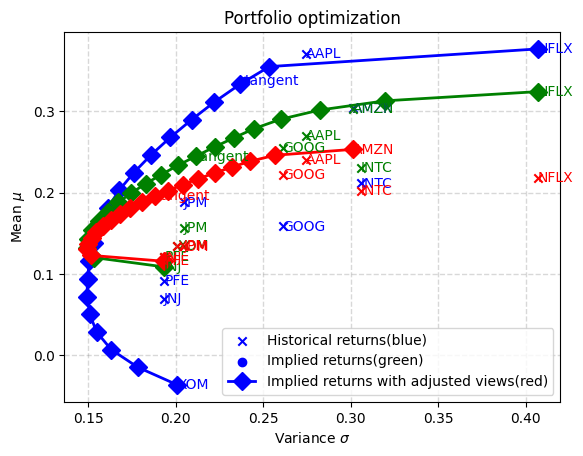

In [33]:
# 1번째 최적화 결과를 차트로 출력
plotAssets(tickers, R, C, color='blue')
plotFrontier(opt1, label='Historical returns', color='blue')

# 2번째 최적화 결과를 차트로 출력
plotAssets(tickers, pi+rf, C, color='green')
plotFrontier(opt2, label='Implied returns', color='green')

# 3번째 최적화 결과를 차트로 출력
plotAssets(tickers, pi_adj+rf, C, color='red')
plotFrontier(opt3, label='Implied returns (adjusted views)', color='red')


plt.rcParams["figure.figsize"] = (12, 10)
plt.grid(alpha=0.3, color='gray', linestyle='--', linewidth=1)
plt.title('Portfolio optimization')
plt.legend(['Historical returns(blue)', 'Implied returns(green)', 'Implied returns with adjusted views(red)'])
plt.xlabel('Variance $\sigma$')
plt.ylabel('Mean $\mu$')
plt.show()